# Pushup Auto Counter Project Final for 4995 Deep Learning in Computer Vision at Columbia

## Journey
The goal of this project is to train a model to recognize different stages of a pushup. Then, to take a video as an input and calculate how many pushups were done. <br>
When I started, it seemed like I was getting really great results, high accuracies on the validation, and the pushup count was very accurate. The problems started when I used videos that were not in the training or validation data at all. I realized that, although the training and validation data sets were completely different, since they came from the same videos, the pictures were not disimilar. Therefore, the networks were not generalizing well. By adding new videos to make the validation data, I was able to create a model that generalized much better. Using early stopping, by saving the model based on the best validation accuracy, I was able to get a model that was around 75% accurate. Although I was hoping for higher, this proved to be high enough to correctly calculate the pushup count. Going forward, I would want to further iterate on my dataset to include a wider variety of people and backgrounds in hopes that my model would generalize better. 

## Data
All the data was completely sources by myself, with the help of many friends who sent in videos of themeselves doing pushups. I used Google Cloud Platform to label and store my data. And you can access the download_data notebook to download the data directly from there! I have over 1200 images, split into 900 for training, 300 for validation. The testing was done using videos (which was split up into images when I ran it). For the testing, I had 4 videos that all preformed well. One of them was from the training set, one from the validation, and 2 that weren't used in either. 

## Big Mistakes
One of the biggest mistakes I made was splitting my training data and validation data randomnly. The problem with doing this is that both datasets were basically identical, as the pictures all came from the same video. This caused my data to not generalize well to videos that were not trained on. So, after testing the data, I added new data and put it all in the validation data so that it had not been seen at all. <br><br>

## Training Part

In [15]:
import torch
import torchvision
from torchvision import models, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import sys
import cv2 as cv
import ffmpeg
device =  torch.device('cuda')

In [3]:
class_name = {
    0: 'down',
    1: 'middle',
    2: 'up'
}
DOWN = 0
MIDDLE = 1
UP = 2

We will start out with a vgg16 network like we did in hw5. I will later try resnet, and compare results. But first, lets load in the pretrained model.

In [95]:
vgg16 = models.vgg16(pretrained=True).to(device)
#print(vgg16.modules)

We will also freeze all the layers except the classification layer, so we can train the model on our data. 

In [96]:
for param in vgg16.parameters():
    param.requires_grad = False
vgg16.classifier._modules['6'] = nn.Linear(4096, 3)

I made sure to size all the data to be the same as my inputs, which were 320x180. I also added the normalize which is reconmended for these pytorch pretrained models.

In [82]:
transform = transforms.Compose([
    transforms.Resize((180, 320)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


trainset = torchvision.datasets.ImageFolder(root='./data/train', transform=transform)
valset = torchvision.datasets.ImageFolder(root='./data/validation', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=16,
                                          shuffle=True)


### Helper Methods
Here I will make a method to get the accuracy of the model, and a method that trains the model, and saves the best versions, based off the validation accuracy. 

In [52]:
def get_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader: 
            images, labels = data[0].to(device), data[1].to(device)
            model.eval()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [12]:
# Used first source from bibliography to help set this up, however, I did not copy and paste. I had already made it,
# but I updated it to have features like time and base it off accuracy instead of loss.
def train(model, epochs, path, best_acc=0.0):
    model.cuda()
    start = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

    running_loss = 0
    for j in range(epochs):
        print('Epoch {}/{}'.format(j, epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            running_loss = 0.0
            running_corrects = 0
            if phase == 'train':
                model.train()
                for i, data in enumerate(trainloader):
                    inputs, labels = data[0].to(device), data[1].to(device) # get mini batch data
                    optimizer.zero_grad() 
                    outputs = model(inputs) 
                    loss = criterion(outputs, labels)
                    _, predicted = torch.max(outputs.data, 1)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(predicted == labels.data)
                epoch_loss = running_loss / len(trainloader.dataset)
                epoch_acc = running_corrects.double() / len(trainloader.dataset)

            else:
                model.eval()
                for i, data in enumerate(valloader):
                    inputs, labels = data[0].to(device), data[1].to(device) # get mini batch data
                    optimizer.zero_grad()
                    with torch.no_grad():
                        outputs = model(inputs) 
                        loss = criterion(outputs, labels)
                        _, predicted = torch.max(outputs.data, 1)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(predicted == labels.data)
                epoch_loss = running_loss / len(valloader.dataset)
                epoch_acc = running_corrects.double() / len(valloader.dataset)

        
            print('{} Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch_loss, epoch_acc * 100))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), path)
                
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc * 100))
    model.load_state_dict(torch.load(path))
    
    return best_acc

In [54]:
train(vgg16, epochs=10, path='vgg16.pth')

Epoch 0/9
----------
train Loss: 0.2526 Acc: 89.8613%
val Loss: 1.1800 Acc: 45.6667%
Epoch 1/9
----------
train Loss: 0.2375 Acc: 90.1814%
val Loss: 1.3204 Acc: 49.3333%
Epoch 2/9
----------
train Loss: 0.2159 Acc: 91.0352%
val Loss: 0.9435 Acc: 57.6667%
Epoch 3/9
----------
train Loss: 0.1789 Acc: 93.0630%
val Loss: 0.9350 Acc: 57.3333%
Epoch 4/9
----------
train Loss: 0.1754 Acc: 93.3831%
val Loss: 0.9273 Acc: 60.0000%
Epoch 5/9
----------
train Loss: 0.1597 Acc: 92.8495%
val Loss: 0.9335 Acc: 61.3333%
Epoch 6/9
----------
train Loss: 0.1634 Acc: 93.9168%
val Loss: 0.7634 Acc: 64.6667%
Epoch 7/9
----------
train Loss: 0.1391 Acc: 95.0907%
val Loss: 1.0518 Acc: 55.3333%
Epoch 8/9
----------
train Loss: 0.1138 Acc: 95.8378%


KeyboardInterrupt: 

I accidentally ran this cell again. But the inital output was about 90% for both the training and validation. (This was before I fixed my datasets to make sure that they took from seperate videos)

Let's take a look at what the pictures looks like, and what the labels are!

In [80]:
import numpy as np

def show_sample(X, y, prediction=-1):
    img = X / 2 + 0.5    
    npimg = img.to('cpu').numpy() # convert back to numpy for plt
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[int(y)], class_name[int(prediction)]))
    else:
        plt.title("Class = %s" % (class_name[int(y)]))
    plt.show()
    # print labels

    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


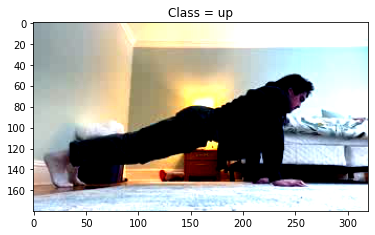

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


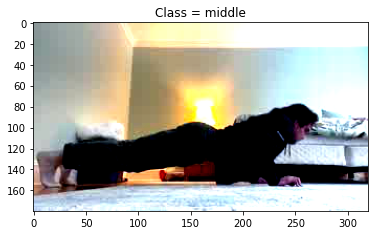

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


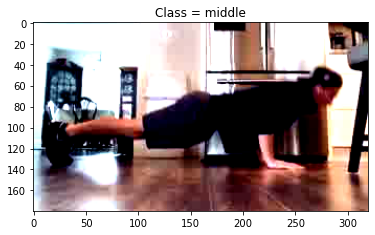

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


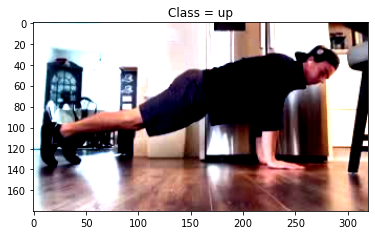

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


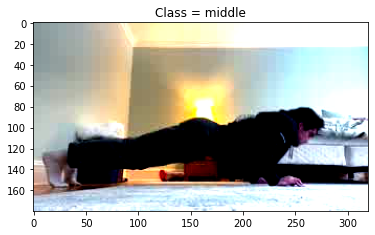

In [84]:
for i, data in enumerate(valloader):
    images, labels = data
    for i in range(5):
        show_sample(images[i], labels[i])
    break

We can now unfreeze the layers, and train again on the network

In [21]:
for param in vgg16.parameters():
    param.requires_grad = True

In [22]:
train(vgg16, epochs=10, path='vgg16.pth')

Epoch 0/9
----------
train Loss: 0.5270 Acc: 81.1749%
val Loss: 0.3544 Acc: 92.5532%
Epoch 1/9
----------
train Loss: 0.3937 Acc: 83.8451%
val Loss: 0.2381 Acc: 94.6809%
Epoch 2/9
----------
train Loss: 0.3282 Acc: 85.4473%
val Loss: 0.1946 Acc: 95.2128%
Epoch 3/9
----------
train Loss: 0.3047 Acc: 88.5180%
val Loss: 0.1659 Acc: 95.7447%
Epoch 4/9
----------
train Loss: 0.2563 Acc: 89.4526%
val Loss: 0.1490 Acc: 95.2128%
Epoch 5/9
----------
train Loss: 0.2587 Acc: 90.5207%
val Loss: 0.2266 Acc: 90.4255%
Epoch 6/9
----------
train Loss: 0.2168 Acc: 92.3899%
val Loss: 0.1671 Acc: 94.6809%
Epoch 7/9
----------
train Loss: 0.2104 Acc: 92.1228%
val Loss: 0.1376 Acc: 94.1489%
Epoch 8/9
----------
train Loss: 0.1807 Acc: 92.3899%
val Loss: 0.1463 Acc: 93.6170%
Epoch 9/9
----------
train Loss: 0.1710 Acc: 93.4579%
val Loss: 0.1413 Acc: 95.7447%
Training complete in 2m 56s
Best val Acc: 95.744681


We see that we achieve a Validation accuracry of around 97% after 10 epochs! Not bad! Let's see how the predictions look

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


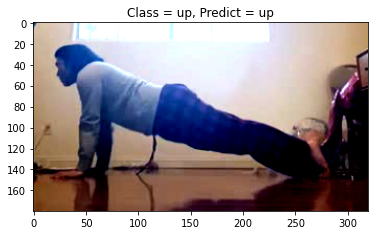

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


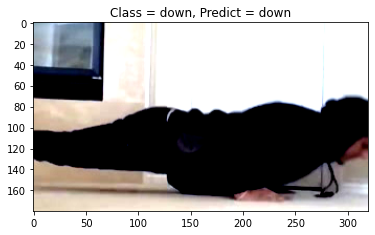

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


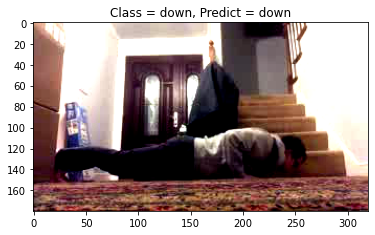

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


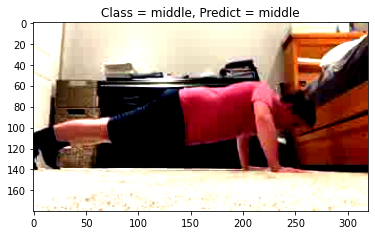

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


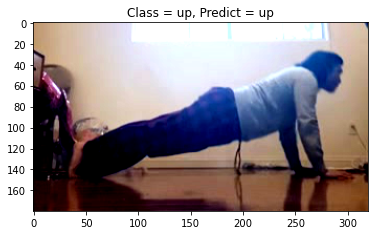

In [23]:
with torch.no_grad():           # Do not update gradients when evaluating
    for i, data in enumerate(valloader):
        images, labels = data[0].to(device), data[1].to(device)
        vgg16.eval() 
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1) # Get the arg max
        for i in range(5):
            show_sample(images[i], labels[i], predicted[i])
        break

Now that we have the model trained, lets test it on some real videos! Since I encountered some weird issues with some videos being rortated, I added in some code I found (second link in the bibliograhy) that was supposed to fix it. However, the mov's didnt have the correct tag, so it didn't work, for now, I'll just limit my test videos to ones that are rotated correctly

In [27]:
def check_rotation(path_video_file):
    # this returns meta-data of the video file in form of a dictionary
    meta_dict = ffmpeg.probe(path_video_file)
    # from the dictionary, meta_dict['streams'][0]['tags']['rotate'] is the key
    # we are looking for
    rotateCode = None
    if int(meta_dict['streams'][0]['tags'].get('rotate')) == 90:
        rotateCode = cv2.ROTATE_90_CLOCKWISE
    elif int(meta_dict['streams'][0]['tags'].get('rotate')) == 180:
        rotateCode = cv2.ROTATE_180
    elif int(meta_dict['streams'][0]['tags'].get('rotate')) == 270:
        rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE

    return rotateCode

def correct_rotation(frame, rotateCode):  
    return cv.rotate(frame, rotateCode) 

Here we use open CV to take a video and turn it into a list of images. We can then use the images to count the pushups!

In [67]:
def get_images(pathIn):
    images = []
    count = 0
    vidcap = cv.VideoCapture(pathIn)
    # rotateCode = check_rotation(pathIn) Currently not using
    success, image = vidcap.read()
    while success:
        vidcap.set(cv.CAP_PROP_POS_MSEC,(count*150))
        # cv2.imwrite(pathOut + f'frame-{count}.jpg', image)     # save frame as JPEG file
#         if rotateCode is not None:
#             image = correct_rotation(image, rotateCode)
        # plt.imshow(image)
        images.append(image)
        count = count + 1
        success,image = vidcap.read()
    print('Finished Extraction')
    return images

In [86]:
from PIL import Image

transform_image = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((180, 320)),  
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def image_loader(image):
    """load image, returns cuda tensor"""
    image = transform_image(image).float()
    #image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

Here, lets just look at the first frame to make sure the video is loading in correctly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


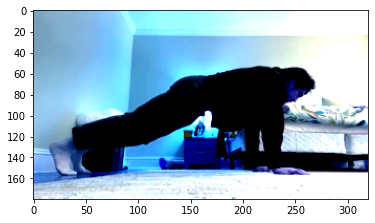

In [49]:
for i in range(1):
    img = image_loader(images_pk[i]) / 2 + 0.5
    npimg = img.to('cpu').numpy() # convert back to numpy for plt
    plt.imshow(np.transpose(npimg[0], (1, 2, 0)))

In [63]:
def count_pushups(model, images, show_20=False, show_last5=False, show_all=False):
    model.cuda()
    last = 0
    status = {
        0: 'start',
        1: 'going down',
        2: 'down',
        3: 'going up'
    }

    failed = 0
    total = 0
    
    with torch.no_grad(): 
        model.eval()
        for i, image in enumerate(images):
            image = image_loader(image) 

            output = model(image)

            _, predicted = torch.max(output.data, 1) # Get the arg max
            state = int(predicted[0])
            if show_all:
                print(f'Frame {i}')
                show_sample(image[0], state)
            else:
                if i < 20 and show_20:
                    print(f'Frame {i}')
                    show_sample(image[0], state)
                if i >= len(images)-5 and show_last5:
                    print(f'Frame {i}')
                    show_sample(image[0], state)
            if state == UP:
                if last == 1:
                    failed += 1
                if last == 2 or last == 3:
                    total += 1
                last = 0
            elif state == MIDDLE:
                if last == 0:
                    last = 1
                if last == 2:
                    last = 3
            else:
                last = 2
        print(f'Total pushups done: {total}, failed pushups: {failed}')


## First Test!
Let's try to count the pushups using a test video that was not part of the training!

In [ ]:
images_pk = get_images('./test_videos/pk.mov')
count_pushups(vgg16, images_pk)

(The output was 0 pushups, sorry I got rid of it accidentally) <br>
Oh no, when using a video that was not part of the training at all, the model does not predict well! I think I will have to change the validation training set, so that we make sure the model is generalizing better. 
Take a look at the begining of this notebook for more info on the change I make.

## Updating the data, and trying again!

In [99]:
vgg16 = models.vgg16(pretrained=True).to(device)
for param in vgg16.parameters():
    param.requires_grad = False
vgg16.classifier._modules['6'] = nn.Linear(4096, 3)

In [100]:
train(vgg16, epochs=10, path='vgg16.pth')

Epoch 0/9
----------
train Loss: 1.0512 Acc: 44.7172%
val Loss: 1.0227 Acc: 48.0000%
Epoch 1/9
----------
train Loss: 0.8388 Acc: 64.6745%
val Loss: 1.0385 Acc: 47.0000%
Epoch 2/9
----------
train Loss: 0.7457 Acc: 70.1174%
val Loss: 1.0685 Acc: 46.6667%
Epoch 3/9
----------
train Loss: 0.6823 Acc: 73.8527%
val Loss: 1.1204 Acc: 44.0000%
Epoch 4/9
----------
train Loss: 0.6523 Acc: 76.3074%
val Loss: 1.1781 Acc: 49.3333%
Epoch 5/9
----------
train Loss: 0.6094 Acc: 79.2956%
val Loss: 1.1737 Acc: 42.0000%
Epoch 6/9
----------
train Loss: 0.5795 Acc: 78.7620%
val Loss: 1.2386 Acc: 44.3333%
Epoch 7/9
----------
train Loss: 0.5492 Acc: 81.4301%
val Loss: 1.2250 Acc: 43.0000%
Epoch 8/9
----------
train Loss: 0.5483 Acc: 78.2284%
val Loss: 1.2959 Acc: 44.6667%
Epoch 9/9
----------
train Loss: 0.5417 Acc: 80.5763%
val Loss: 1.3073 Acc: 42.6667%
Training complete in 1m 31s
Best val Acc: 49.333333


tensor(0.4933, device='cuda:0', dtype=torch.float64)

After fixing the data, we see quickly that it is not generalizing as well as we thought, let's see if we can get it higher after unfreezing, and we can also try some other networks, such as resnext and resnet

In [101]:
for param in vgg16.parameters():
    param.requires_grad = True
train(vgg16, epochs=10, path='vgg16.pth')

Epoch 0/9
----------
train Loss: 0.5276 Acc: 78.5486%
val Loss: 1.3236 Acc: 50.3333%
Epoch 1/9
----------
train Loss: 0.3619 Acc: 86.5528%
val Loss: 1.3064 Acc: 39.6667%
Epoch 2/9
----------
train Loss: 0.2861 Acc: 87.9402%
val Loss: 1.3049 Acc: 46.6667%
Epoch 3/9
----------
train Loss: 0.2141 Acc: 91.6756%
val Loss: 1.4237 Acc: 49.3333%
Epoch 4/9
----------
train Loss: 0.1865 Acc: 93.0630%
val Loss: 1.6682 Acc: 42.3333%
Epoch 5/9
----------
train Loss: 0.1782 Acc: 92.6361%
val Loss: 1.0618 Acc: 50.0000%
Epoch 6/9
----------
train Loss: 0.1621 Acc: 93.7033%
val Loss: 1.4077 Acc: 49.3333%
Epoch 7/9
----------
train Loss: 0.1456 Acc: 95.6243%
val Loss: 1.3900 Acc: 50.3333%
Epoch 8/9
----------
train Loss: 0.1065 Acc: 95.9445%
val Loss: 1.3420 Acc: 50.0000%
Epoch 9/9
----------
train Loss: 0.0995 Acc: 95.9445%
val Loss: 1.2737 Acc: 54.0000%
Training complete in 3m 28s
Best val Acc: 54.000000


tensor(0.5400, device='cuda:0', dtype=torch.float64)

54% wont cut it for us. Let's try using some different neural nets to see if others perform better

In [102]:
resnext50 = models.resnext50_32x4d(pretrained=True).to(device)

In [103]:
for param in resnext50.parameters():
    param.requires_grad = False
resnext50.fc = nn.Linear(2048, 3)

In [104]:
train(resnext50, epochs=10, path='resnext50.pth')

Epoch 0/9
----------
train Loss: 1.1058 Acc: 31.9104%
val Loss: 1.0776 Acc: 38.6667%
Epoch 1/9
----------
train Loss: 1.0553 Acc: 46.1046%
val Loss: 1.0783 Acc: 40.0000%
Epoch 2/9
----------
train Loss: 1.0032 Acc: 56.1366%
val Loss: 1.0772 Acc: 39.0000%
Epoch 3/9
----------
train Loss: 0.9625 Acc: 62.4333%
val Loss: 1.0840 Acc: 40.3333%
Epoch 4/9
----------
train Loss: 0.9224 Acc: 67.0224%
val Loss: 1.1243 Acc: 36.6667%
Epoch 5/9
----------
train Loss: 0.8932 Acc: 67.8762%
val Loss: 1.0965 Acc: 43.0000%
Epoch 6/9
----------
train Loss: 0.8623 Acc: 68.5165%
val Loss: 1.0851 Acc: 42.3333%
Epoch 7/9
----------
train Loss: 0.8318 Acc: 74.4931%
val Loss: 1.1243 Acc: 47.3333%
Epoch 8/9
----------
train Loss: 0.8120 Acc: 76.3074%
val Loss: 1.1029 Acc: 43.0000%
Epoch 9/9
----------
train Loss: 0.7952 Acc: 75.6670%
val Loss: 1.1090 Acc: 45.6667%
Training complete in 1m 24s
Best val Acc: 47.333333


tensor(0.4733, device='cuda:0', dtype=torch.float64)

47% before we unfreeze, not looking promising

In [105]:
train(resnext50, epochs=15, path='resnext50.pth')

Epoch 0/14
----------
train Loss: 0.8177 Acc: 75.7737%
val Loss: 1.1280 Acc: 46.0000%
Epoch 1/14
----------
train Loss: 0.7938 Acc: 76.3074%
val Loss: 1.1054 Acc: 47.3333%
Epoch 2/14
----------
train Loss: 0.7699 Acc: 78.7620%
val Loss: 1.1388 Acc: 46.3333%
Epoch 3/14
----------
train Loss: 0.7571 Acc: 77.4813%
val Loss: 1.1673 Acc: 47.3333%
Epoch 4/14
----------
train Loss: 0.7326 Acc: 79.2956%
val Loss: 1.1880 Acc: 45.6667%
Epoch 5/14
----------
train Loss: 0.7193 Acc: 79.7225%
val Loss: 1.1759 Acc: 44.0000%
Epoch 6/14
----------
train Loss: 0.7031 Acc: 79.4023%
val Loss: 1.1955 Acc: 46.3333%
Epoch 7/14
----------
train Loss: 0.6856 Acc: 82.3906%
val Loss: 1.2287 Acc: 47.3333%
Epoch 8/14
----------
train Loss: 0.6723 Acc: 82.7108%
val Loss: 1.1851 Acc: 47.0000%
Epoch 9/14
----------
train Loss: 0.6556 Acc: 83.3511%
val Loss: 1.2141 Acc: 47.0000%
Epoch 10/14
----------
train Loss: 0.6612 Acc: 83.3511%
val Loss: 1.2810 Acc: 46.3333%
Epoch 11/14
----------
train Loss: 0.6376 Acc: 85.272

tensor(0.4733, device='cuda:0', dtype=torch.float64)

47% still, uh oh! Hopefully resnet 152 will be the one!

In [87]:
resnet152 = models.resnet152(pretrained=True).to(device)

In [88]:
for param in resnet152.parameters():
    param.requires_grad = False
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, 3)

I'll let this train for 20 epochs as well (results of first 15 were cut off due to connection error)

In [90]:
train(resnet152, epochs=20, path='resnet152.pth')

Epoch 0/19
----------
train Loss: 1.0937 Acc: 37.0331%
val Loss: 1.0785 Acc: 44.6667%
Epoch 1/19
----------
train Loss: 1.0362 Acc: 49.3063%
val Loss: 1.0670 Acc: 44.3333%
Epoch 2/19
----------
train Loss: 0.9939 Acc: 59.4450%
val Loss: 1.0541 Acc: 45.6667%
Epoch 3/19
----------
train Loss: 0.9530 Acc: 61.1526%
val Loss: 1.0453 Acc: 54.3333%
Epoch 4/19
----------
train Loss: 0.9232 Acc: 64.9947%
val Loss: 1.0356 Acc: 45.6667%
Epoch 5/19
----------
train Loss: 0.8838 Acc: 69.6905%
val Loss: 1.0336 Acc: 46.6667%
Epoch 6/19
----------
train Loss: 0.8569 Acc: 73.6393%
val Loss: 1.0301 Acc: 48.3333%
Epoch 7/19
----------
train Loss: 0.8388 Acc: 73.5326%
val Loss: 1.0155 Acc: 55.0000%
Epoch 8/19
----------
train Loss: 0.8067 Acc: 75.3469%
val Loss: 1.0155 Acc: 49.3333%
Epoch 9/19
----------
train Loss: 0.7893 Acc: 76.6275%
val Loss: 1.0041 Acc: 56.0000%
Epoch 10/19
----------
train Loss: 0.7846 Acc: 74.5998%
val Loss: 1.0058 Acc: 51.6667%
Epoch 11/19
----------
train Loss: 0.7522 Acc: 78.655

tensor(0.5867, device='cuda:0', dtype=torch.float64)

59% after 20 epochs, not bad. Let's see how high we can get to after we unfreeze.

In [92]:
for param in resnet152.parameters():
    param.requires_grad = True

In [93]:
train(resnet152, epochs=10, path='resnet152.pth')

Epoch 0/9
----------
train Loss: 0.6289 Acc: 82.7108%
val Loss: 0.9260 Acc: 61.0000%
Epoch 1/9
----------
train Loss: 0.4676 Acc: 89.4344%
val Loss: 0.8834 Acc: 58.6667%
Epoch 2/9
----------
train Loss: 0.3668 Acc: 91.2487%
val Loss: 0.8400 Acc: 67.3333%
Epoch 3/9
----------
train Loss: 0.2921 Acc: 93.3831%
val Loss: 0.8085 Acc: 66.0000%
Epoch 4/9
----------
train Loss: 0.2429 Acc: 94.5571%
val Loss: 0.7845 Acc: 66.3333%
Epoch 5/9
----------
train Loss: 0.2323 Acc: 93.9168%
val Loss: 0.7816 Acc: 65.6667%
Epoch 6/9
----------
train Loss: 0.1661 Acc: 96.3714%
val Loss: 0.7748 Acc: 69.6667%
Epoch 7/9
----------
train Loss: 0.1419 Acc: 97.7588%
val Loss: 0.7656 Acc: 71.3333%
Epoch 8/9
----------
train Loss: 0.1314 Acc: 97.5454%
val Loss: 0.7734 Acc: 71.6667%
Epoch 9/9
----------
train Loss: 0.1179 Acc: 97.7588%
val Loss: 0.7682 Acc: 67.3333%
Training complete in 5m 12s
Best val Acc: 71.666667


tensor(0.7167, device='cuda:0', dtype=torch.float64)

72% is starting to look like something we can work with! Maybe we can try some epochs a few at a time. Allowing for more randomization to happen at the best points of the model (when the val acc is highest)

In [96]:
acc = .72
for i in range(3):
    acc = train(resnet152, epochs=3, path='resnet152.pth', best_acc=acc)

Epoch 0/2
----------
train Loss: 0.1115 Acc: 97.6521%
val Loss: 0.7616 Acc: 71.6667%
Epoch 1/2
----------
train Loss: 0.0891 Acc: 99.0395%
val Loss: 0.7678 Acc: 69.3333%
Epoch 2/2
----------
train Loss: 0.0861 Acc: 98.3991%
val Loss: 0.7877 Acc: 71.3333%
Training complete in 1m 29s
Best val Acc: 72.000000
Epoch 0/2
----------
train Loss: 0.1079 Acc: 98.0790%
val Loss: 0.7593 Acc: 73.3333%
Epoch 1/2
----------
train Loss: 0.0976 Acc: 98.0790%
val Loss: 0.7718 Acc: 71.3333%
Epoch 2/2
----------
train Loss: 0.0952 Acc: 98.5059%
val Loss: 0.7813 Acc: 71.0000%
Training complete in 1m 33s
Best val Acc: 73.333333
Epoch 0/2
----------
train Loss: 0.1033 Acc: 98.6126%
val Loss: 0.7831 Acc: 68.3333%
Epoch 1/2
----------
train Loss: 0.0959 Acc: 98.0790%
val Loss: 0.7788 Acc: 72.6667%
Epoch 2/2
----------
train Loss: 0.0889 Acc: 98.1857%
val Loss: 0.8166 Acc: 66.0000%
Training complete in 1m 31s
Best val Acc: 73.333333


It looks like we are getting into over fitting zone if we go much further. However, although this doesn't look all that great, the program does not have to be right every frame to see a pushup, so I think this will do! Resnet152 it is!

## Testing
If you did not run the training yourself, load in the models here before running the tests <br>

In [97]:
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.classifier._modules['6'] = nn.Linear(4096, 3)
vgg16.load_state_dict(torch.load('vgg16.pth'))

resnext50 = models.resnext50_32x4d(pretrained=True).to(device)
num_ftrs = resnext50.fc.in_features
resnext50.fc = nn.Linear(num_ftrs, 3)
resnext50.load_state_dict(torch.load('resnext50.pth'))

resnet152 = models.resnet152(pretrained=True).to(device)
num_ftrs = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs, 3)
resnet152.load_state_dict(torch.load('resnet152.pth'))

<All keys matched successfully>

### Case 1: Video that was used in Training
Let's try using a video that was used for the training, to simply test if our algorithm works well. We expect to see <b>30</b> pushups.
<br>
For all of the testing, I will be using resnet152

In [98]:
images_train = get_images('./test_videos/nick.mov')

Finished Extraction


In [77]:
count_pushups(resnet152, images_train)

Total pushups done: 30, failed pushups: 0


It worked! Let's take a look at some cases. Again, this data was used in training, but atleast the algorithm looks good!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 235


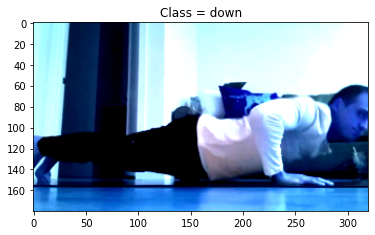

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 236


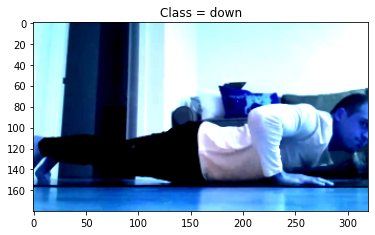

Frame 237


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


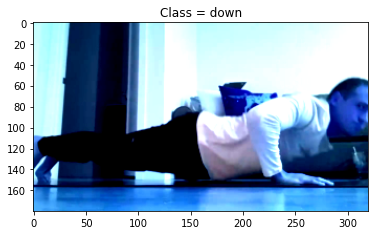

Frame 238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


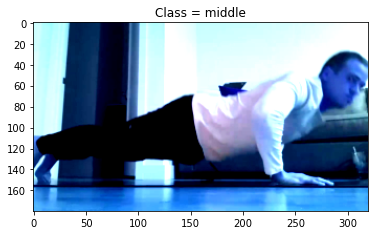

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 239


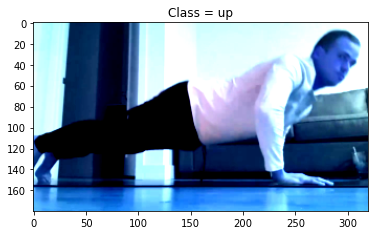

Total pushups done: 30, failed pushups: 0


In [78]:
count_pushups(resnet152, images_train, show_20=False, show_last5=True)

Yep! The issue is that the last frame was taken early, so it did not include the fully up position. This could be fixed by adding a bit of buffer time to the video at the end (1 second would be plenty).

### Case 2: Video not used for Training or Validation!
This test video has not been used at all for either the training or validation datasets. It's a video of me, in a background that is also brand new. <br>
I did <b>22</b> pushups in this video (I can do more... I was just tired. REALLY I CAN)

In [73]:
images = get_images('./test_videos/joey3.mov')

Finished Extraction


In [74]:
count_pushups(resnet152, images)

Total pushups done: 21, failed pushups: 0


Ah, looks like we are one short. Let's look at the last 5, I think it may be due to the last frame not being close enough to the end. We will fix this for later videos. Good news is that its generalizing well!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 182


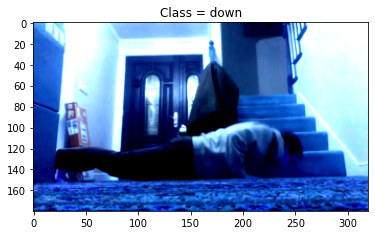

Frame 183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


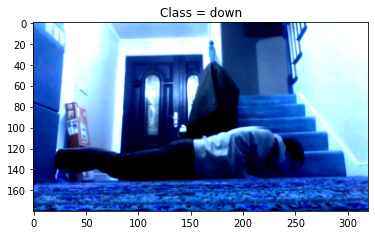

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 184


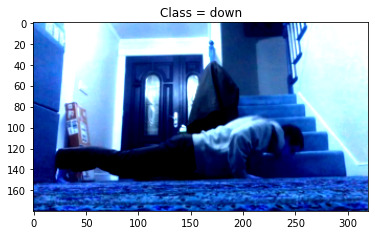

Frame 185


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


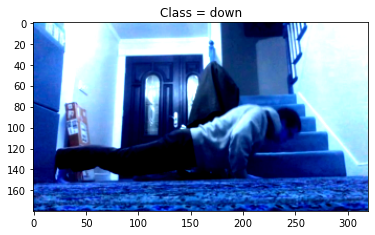

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 186


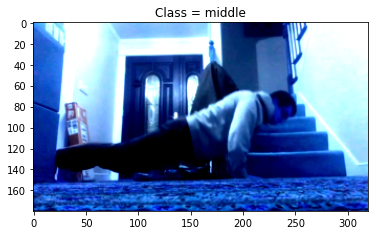

Total pushups done: 21, failed pushups: 0


In [75]:
count_pushups(resnet152, images, show_20=False, show_last5=True)

Indeed, it is due to the last frame. The labelling looks fine for that frame, the video just seemed to end a bit early. Overal it looks really good! Frame 185 should be middle, however, it does not cause an issue in the result. 
Keep in mind, although this video wasnt used for training (nor the background), other videos of myself was used. So let's take a look at videos that weren't trained on next!

## Case 3: New person, but images used in validation
Let's take a look at a video that was used for the validation data. This will be interesting, because the training data never saw these people at all! So if it works on them, it should work on most people! We expect to see 20 pushups here!

In [71]:
images_pk = get_images('./test_videos/pk.mov')

Finished Extraction


In [72]:
count_pushups(resnet152, images_pk)

Total pushups done: 20, failed pushups: 0


It works! It was able to count exactly correct. Let's take a look at the first 20 just to make sure it looks good.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


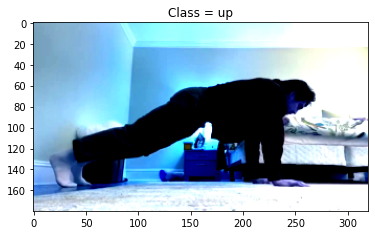

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


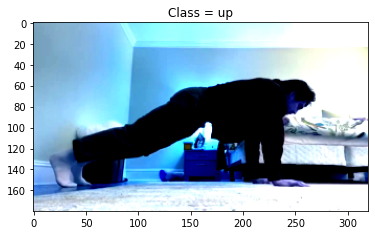

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


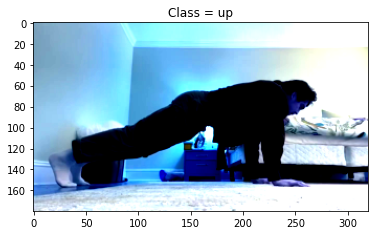

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


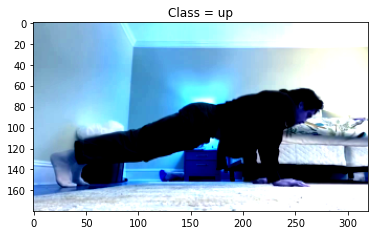

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


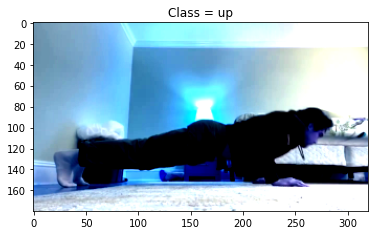

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


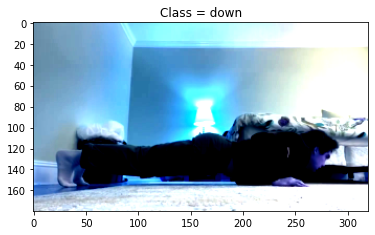

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


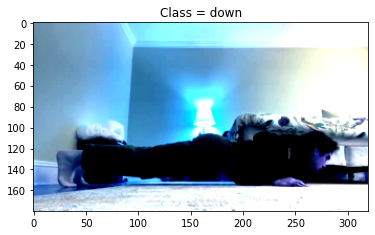

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


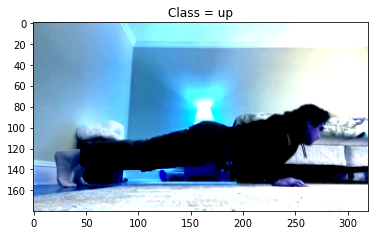

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


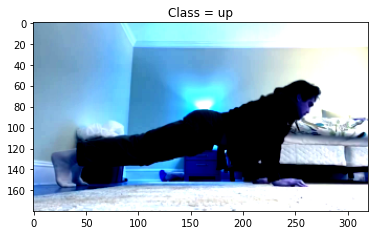

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


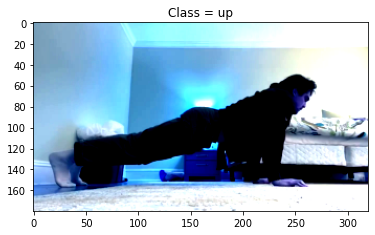

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


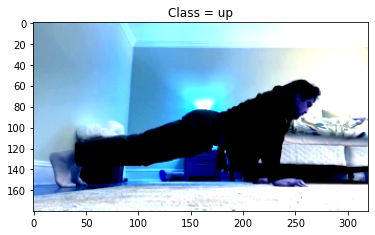

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


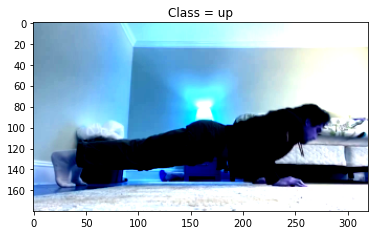

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


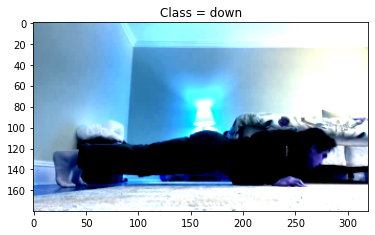

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


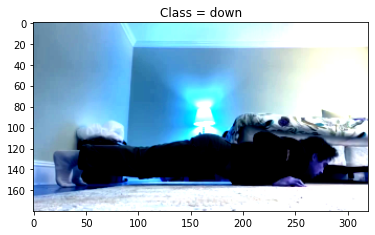

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


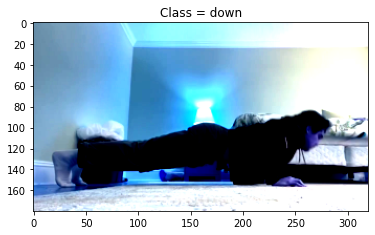

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


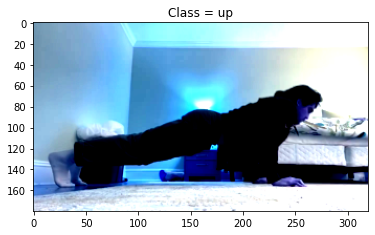

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


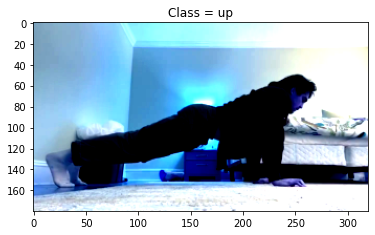

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


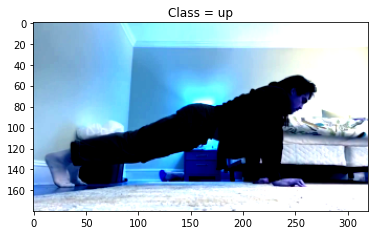

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


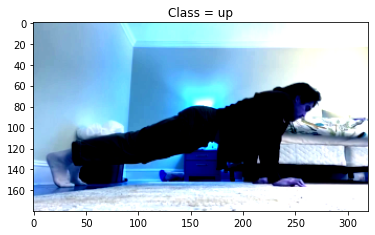

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


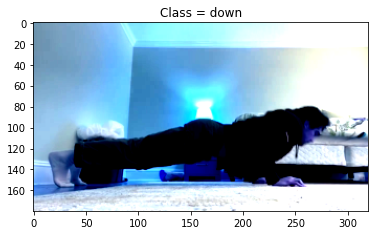

Total pushups done: 21, failed pushups: 0


In [47]:
count_pushups(resnet152, images_pk, show_20=True, show_last5=False)

We seem to have lost the middle class largely, which didn't affect the overal count, but could definitely cause issues in the future. I wonder if it is because the dark clothes, or a different form than others. Let me try another video and see what the result is! Regardless, it may mean that I need a larger variety of data to train on.

## Case 4: New person, data completely new!
This video is not used for training, and neither was the person in a different video! We expect to see <b>6</b> Pushups here!

In [68]:
images_anthony = get_images('./test_videos/anthonyk.mov')

Finished Extraction


In [69]:
count_pushups(resnet152, images_anthony)

Total pushups done: 6, failed pushups: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 0


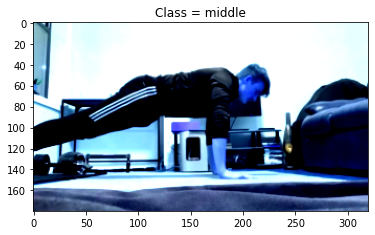

Frame 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


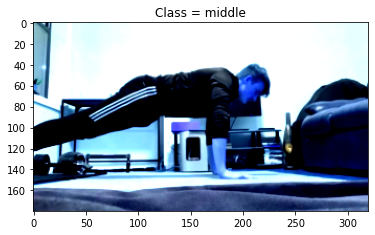

Frame 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


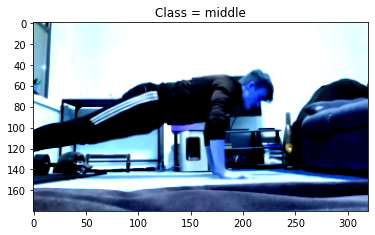

Frame 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


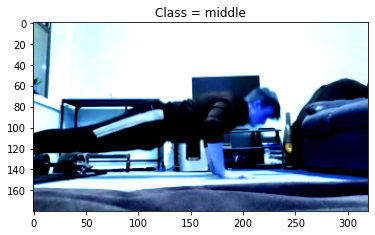

Frame 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


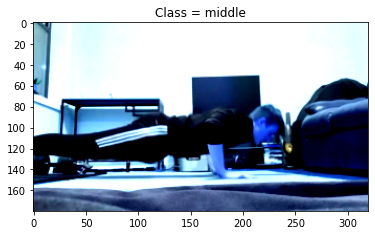

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 5


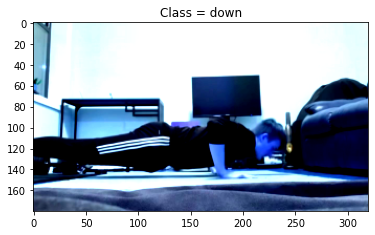

Frame 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


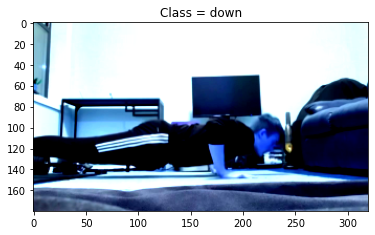

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 7


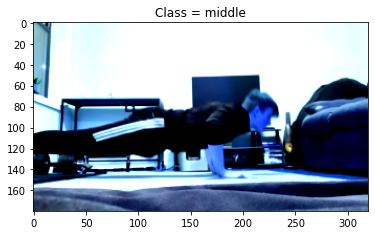

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 8


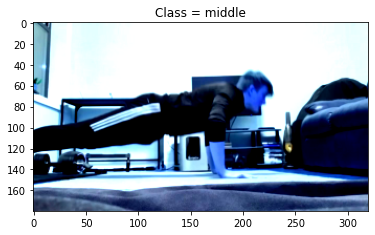

Frame 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


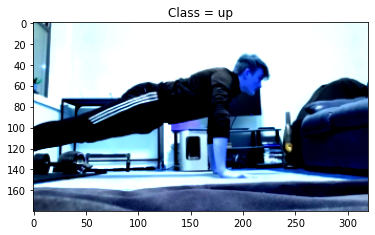

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 10


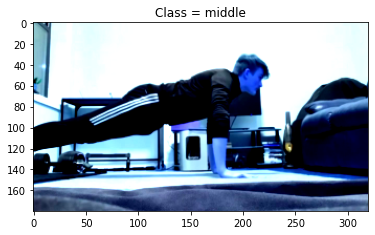

Frame 11


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


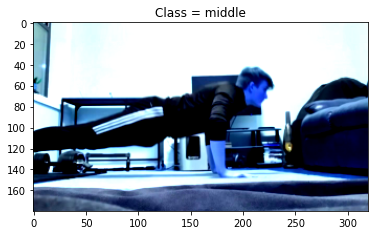

Frame 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


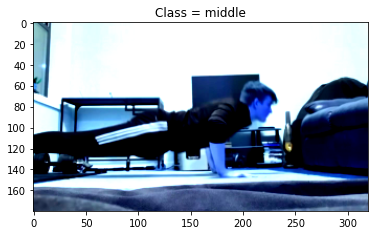

Frame 13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


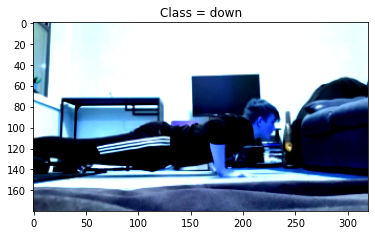

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 14


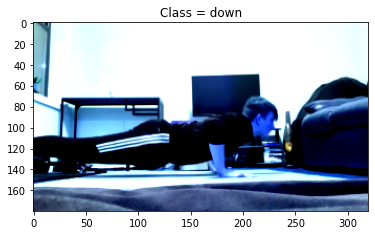

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 15


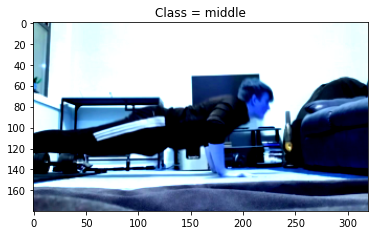

Frame 16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


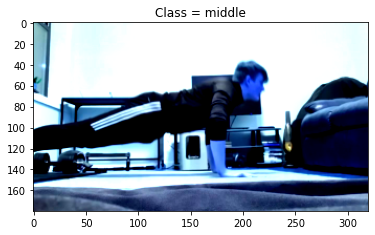

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 17


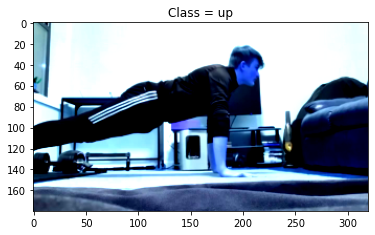

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Frame 18


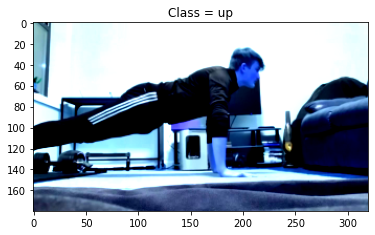

Frame 19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


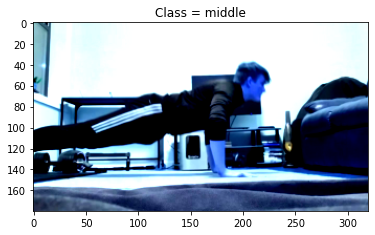

Total pushups done: 6, failed pushups: 0


In [70]:
count_pushups(resnet152, images_anthony, show_20=True)

I dont see anything too wrong here. It does seem to start the first frame in the middle, but that shouldn't affect the count. Mission success!

Overall, I would say this project was a success! The main change I would make, if I were to do it again, would be to my data. Although I probably spent over 10 hours collecting, labeling, and importing data. The main change I would make would be to take less images from each video. I took so many images from each video, and labeled them all, but they ended up being very similar. It would have been better to have less data, but potentially more diverse data. Given a chance to do it again, I would take ~20 frames from each video, only ask for about 5 pushups from each friend, and hopefully get ~200 images of each label. 

Bibliography: <br>
Documentation on training different networks https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html <br>
Check Rotations to fix videos https://stackoverflow.com/questions/53097092/frame-from-video-is-upside-down-after-extracting <br>